# Analyse de données sur les données ABR

## Initialisation et Séparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import warnings
warnings.filterwarnings('ignore')

In [169]:
appreciation_color_map = {'green':"appréciés", 'blue':"plus-ou-moins-appréciés", 'red':"non-appréciés"}

def pca_scatter2d(X,Y,c=False,bar=False,df_bar=None,title=False):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121) if bar else fig.add_subplot(111)
    ax.set_xlabel('Composante Principale 1', fontsize = 10)
    ax.set_ylabel('Composante Principale 2', fontsize = 10)
    if isinstance(c,bool):
        ax.set_title('2D PCA', fontsize = 13)
        plt.scatter(X,Y)
    else:
        ax.set_title('2D PCA Colors', fontsize = 13)
        plt.scatter(X,Y,c=c)
        
        patches = [plt.plot([],[],ls='', marker='.', color=color, label=value)[0] for color,value in appreciation_color_map.items()]
        plt.legend(handles=patches)
    
    if bar:
        ax1 = fig.add_subplot(122)
        ax1.set_xlabel("Niveau d'appreciation", fontsize = 10)
        ax1.set_title('Appreciation des livres', fontsize = 13)

        df_bar.plot.bar(color='darkolivegreen',ax=ax1,rot=0)

    if title:
        fig.suptitle(title)

def pca_scatter3d(X,Y,Z,c=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d') 
    ax.set_xlabel('Composante Principale 1', fontsize = 5)
    ax.set_ylabel('Composante Principale 2', fontsize = 5)
    ax.set_zlabel('Composante Principale 3', fontsize = 5)
    if isinstance(c,bool):
        ax.set_title('3D PCA', fontsize = 13)
        plt.scatter(X,Y,Z)
    else:
        ax.set_title('3D PCA', fontsize = 13)
        plt.scatter(X,Y,Z,c=c)

        patches = [plt.plot([],[],ls='', marker='.', color=color, label=value)[0] for color,value in appreciation_color_map.items()]
        plt.legend(handles=patches)


In [ ]:
sc = SparkSession.builder.master("local").appName("Test").getOrCreate()
def get_sample(partition:int,fields:list,dataset_path:str):
    ''' Sépare les données en pourcentage'''
    df = sc.read.json(dataset_path)
    df_overall = df[fields]

    pourcentage = partition/100
    df_sample = df.sample(pourcentage)
    df_sample_pd = df_sample.toPandas()
    df_sample_pd.to_csv(f'sample_{partition}p.csv')


dataset_path = "../Data/Books_5.json"
fields = ['overall','asin','reviewTime']
partition_pourcentage = 2 # pourcentage

get_sample(partition_pourcentage,fields,dataset_path)

## A - Traitement des données et diagrame moustache

In [146]:
df_data = pd.read_csv('sample_5p.csv')
categories_limites = (2.8,4.25)
categories_limites_ajuste = [4.5,6.5]
colors = ('red','blue','green')
pond_moyenne = lambda moyenne,nbr : moyenne*(1+np.log(nbr))
PCA_nbr = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5']

PC_x, PC_y, PC_z = PCA_nbr[0],PCA_nbr[1], PCA_nbr[3]

### Exploration

In [147]:
df_data['reviewTime'] = pd.to_datetime(df_data['reviewTime'])
df_observations = df_data[['overall','asin']].value_counts().reset_index(name='counts')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445761 entries, 0 to 445760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  445761 non-null  int64         
 1   overall     445761 non-null  float64       
 2   asin        445761 non-null  object        
 3   reviewTime  445761 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 13.6+ MB


### Matrice

In [17]:
df_matrice_donnes = df_observations.pivot(index='overall', columns='asin')
df_matrice_donnes = df_matrice_donnes.droplevel(0, axis=1)
df_matrice_donnes = df_matrice_donnes.fillna(0)
df_matrice_donnes

asin,000100039X,0001055178,0001473905,000171287X,0001714538,0002006715,0002007770,0002008572,0002051850,0002113570,...,B00LY51TPA,B00LYGQXQY,B00LYH0JD6,B00LYM5AUI,B00LYPZJ4M,B00LZ4D0UC,B00LZ9OBWI,B00LZFHL7Y,B00LZKMXBI,B00M0RE7CS
overall,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,2.0,0.0,0.0,0.0,0.0,28.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5.0,12.0,0.0,1.0,3.0,1.0,1.0,101.0,2.0,8.0,1.0,...,2.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,7.0,2.0


In [18]:
df_matrice_donnes.loc['total'] = df_matrice_donnes.sum()
df_matrice_donnes_ = df_data[['asin','overall']].groupby('asin').agg(note_min=('overall', 'min'),
                                                                                note_max=('overall', 'max'),
                                                                                note_std=('overall', 'std'),
                                                                                note_median=('overall', 'median'),
                                                                                moyenne_pondere=('overall', 'mean')).fillna(0)
df_matrice_donnes_

,note_min,note_max,note_std,note_median,moyenne_pondere
asin,,,,,
000100039X,5.0,5.0,0.000000,5.0,5.000
0001055178,4.0,4.0,0.000000,4.0,4.000
0001473905,5.0,5.0,0.000000,5.0,5.000
000171287X,3.0,5.0,1.000000,5.0,4.500
0001714538,5.0,5.0,0.000000,5.0,5.000
...,...,...,...,...,...
B00LZ4D0UC,5.0,5.0,0.000000,5.0,5.000
B00LZ9OBWI,5.0,5.0,0.000000,5.0,5.000
B00LZFHL7Y,5.0,5.0,0.000000,5.0,5.000


In [43]:
df_moyenne_pondere = df_matrice_donnes_[['moyenne_pondere','note_median']]


df_matrice_donnes_description = pd.concat([df_matrice_donnes,df_matrice_donnes_.T])
df_matrice_donnes_description

asin,000100039X,0001055178,0001473905,000171287X,0001714538,0002006715,0002007770,0002008572,0002051850,0002113570,...,B00LY51TPA,B00LYGQXQY,B00LYH0JD6,B00LYM5AUI,B00LYPZJ4M,B00LZ4D0UC,B00LZ9OBWI,B00LZFHL7Y,B00LZKMXBI,B00M0RE7CS
1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3.0,0.0,0.0,0.0,1.0,0.0,0.0,14.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4.0,0.0,2.0,0.0,0.0,0.0,0.0,28.000000,0.0,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0
5.0,12.0,0.0,1.0,3.0,1.0,1.0,101.000000,2.0,8.000000,1.0,...,2.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,7.000000,2.0
total,12.0,2.0,1.0,4.0,1.0,1.0,155.000000,2.0,10.000000,1.0,...,2.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,8.000000,2.0
note_min,5.0,4.0,5.0,3.0,5.0,5.0,1.000000,5.0,3.000000,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.000000,5.0
note_max,5.0,4.0,5.0,5.0,5.0,5.0,5.000000,5.0,5.000000,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,5.0
note_std,0.0,0.0,0.0,1.0,0.0,0.0,1.056946,0.0,0.674949,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353553,0.0
note_median,5.0,4.0,5.0,5.0,5.0,5.0,5.000000,5.0,5.000000,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.000000,5.0


In [200]:
df_mp = df_moyenne_pondere.loc[:,'moyenne_pondere'].to_frame().describe()
score_min = df_mp.loc["min"].to_list()[0]
score_max = df_mp.loc["max"].to_list()[0]
df_mp

,moyenne_pondere
count,179924.000000
mean,4.252820
std,0.915878
min,1.000000
25%,4.000000
50%,4.500000
75%,5.000000
max,5.000000


### 1) Moyenne de score

In [24]:
df_affichage_moyenne_p = df_moyenne_pondere.loc[:,'moyenne_pondere'].to_frame()
print('La moyenne de score de chaque livre:')
df_affichage_moyenne_p

La moyenne de score de chaque livre:


,moyenne_pondere
asin,
000100039X,5.000
0001055178,4.000
0001473905,5.000
000171287X,4.500
0001714538,5.000
...,...
B00LZ4D0UC,5.000
B00LZ9OBWI,5.000
B00LZFHL7Y,5.000


In [27]:
moyenne_globale = df_moyenne_pondere[['moyenne_pondere']].mean()
print(f'On peux supposer que la moyenne pondere: {round(moyenne_globale.values[0],2)} nous indique si le livre est bon ou pas')

On peux supposer que la moyenne pondere: 4.25 nous indique si le livre est bon ou pas


### 2) Livres les mieux appréciés

In [204]:
top_livres_m = df_moyenne_pondere.loc[df_moyenne_pondere['moyenne_pondere'] == score_max]
top_livres_m = top_livres_m.sort_values(by=['moyenne_pondere'], ascending=False)
print('Le top des livres les plus appréciés basé sur la moyenne max sont:')
top_livres_m

Le top des livres les plus appréciés basé sur la moyenne max sont:


,moyenne_pondere,note_median,moyenne_ajuste
asin,,,
000100039X,5.0,5.0,17.424533
1595828885,5.0,5.0,5.000000
1595823697,5.0,5.0,5.000000
1595823476,5.0,5.0,5.000000
1595822836,5.0,5.0,5.000000
...,...,...,...
0786018127,5.0,5.0,5.000000
0786018089,5.0,5.0,5.000000
0786017708,5.0,5.0,8.465736


In [205]:
bottom_livres_m = df_moyenne_pondere.loc[df_moyenne_pondere['moyenne_pondere'] == score_min]
bottom_livres_m = bottom_livres_m.sort_values(by=['moyenne_pondere'], ascending=True)
print('Les les moins appréciés basé sur la moyenne min sont:')
bottom_livres_m

Les les moins appréciés basé sur la moyenne min sont:


,moyenne_pondere,note_median,moyenne_ajuste
asin,,,
0007164785,1.0,1.0,1.000000
1581125844,1.0,1.0,1.000000
1581347561,1.0,1.0,1.000000
1581348665,1.0,1.0,1.000000
1581351127,1.0,1.0,1.000000
...,...,...,...
0758207921,1.0,1.0,1.000000
0758210248,1.0,1.0,1.000000
0758213212,1.0,1.0,1.000000


### 3) 1er quart des livres les plus appréciés

In [31]:
quartile = top_livres_m.quantile(0.25)
print("Le premier quart des livres les plus appéciés est: ",quartile.values[0])
top_livres_m.describe()

Le premier quart des livres les plus appéciés est:  4.75


,moyenne_pondere,note_median
count,103061.000000,103061.000000
mean,4.872773,4.920775
std,0.219348,0.212313
min,4.254237,4.000000
25%,4.750000,5.000000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


### 4) En se basant sur la moyenne on peux dire que le livre qui a la plus grande moyenne est plus apprécié

### 5) La moyenne n'est pas vraiment efficace dans notre cas, on devrai plutot modifier la moyenne en se basant sur la quantité de notes que le livre a recu. On utiliseras alors une transformation non linéaire qui ajuste les notes des livres en fonction du nombre de notes: $note * (1+\ln({nbr\_note}))$

In [45]:
df_tmp1 = df_data['asin'].value_counts().rename_axis('asin').to_frame('counts')
df_tmp2 = df_moyenne_pondere[["moyenne_pondere"]]
df_tmp3 = df_tmp2.merge(df_tmp1,on='asin')

df_moyenne_pondere["moyenne_ajuste"] = df_tmp3.apply(lambda x: pond_moyenne(x["moyenne_pondere"],x["counts"]),axis=1)

df_matrice_donnes_description = pd.concat([df_matrice_donnes,df_moyenne_pondere.T])
df_matrice_donnes_description

asin,000100039X,0001055178,0001473905,000171287X,0001714538,0002006715,0002007770,0002008572,0002051850,0002113570,...,B00LY51TPA,B00LYGQXQY,B00LYH0JD6,B00LYM5AUI,B00LYPZJ4M,B00LZ4D0UC,B00LZ9OBWI,B00LZFHL7Y,B00LZKMXBI,B00M0RE7CS
1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,6.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
2.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,6.000000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,14.000000,0.000000,1.00000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4.0,0.000000,2.000000,0.0,0.000000,0.0,0.0,28.000000,0.000000,1.00000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000
5.0,12.000000,0.000000,1.0,3.000000,1.0,1.0,101.000000,2.000000,8.00000,1.0,...,2.000000,2.000000,2.000000,1.0,3.000000,1.0,1.0,2.000000,7.000000,2.000000
total,12.000000,2.000000,1.0,4.000000,1.0,1.0,155.000000,2.000000,10.00000,1.0,...,2.000000,2.000000,2.000000,1.0,3.000000,1.0,1.0,2.000000,8.000000,2.000000
moyenne_pondere,5.000000,4.000000,5.0,4.500000,5.0,5.0,4.367742,5.000000,4.70000,5.0,...,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0,5.000000,4.875000,5.000000
note_median,5.000000,4.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000,5.00000,5.0,...,5.000000,5.000000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000,5.000000
moyenne_ajuste,17.424533,6.772589,5.0,10.738325,5.0,5.0,26.396121,8.465736,15.52215,5.0,...,8.465736,8.465736,8.465736,5.0,10.493061,5.0,5.0,8.465736,15.012278,8.465736


### 6) Diagramme en moustaches

<AxesSubplot: title={'center': 'counts'}, xlabel='overall'>

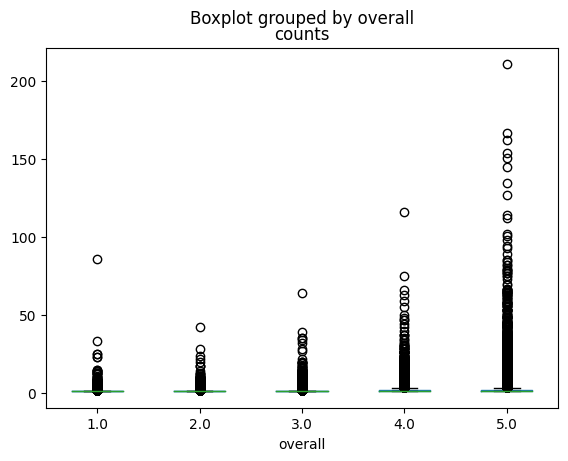

In [85]:
%matplotlib inline
df_observations.boxplot(by="overall",column=['counts'],grid=False)

#### Afin de mieux visualiser le diagramme en moustaches, on peux appliquer un log, et on obtient:

<AxesSubplot: title={'center': 'counts_ln'}, xlabel='overall'>

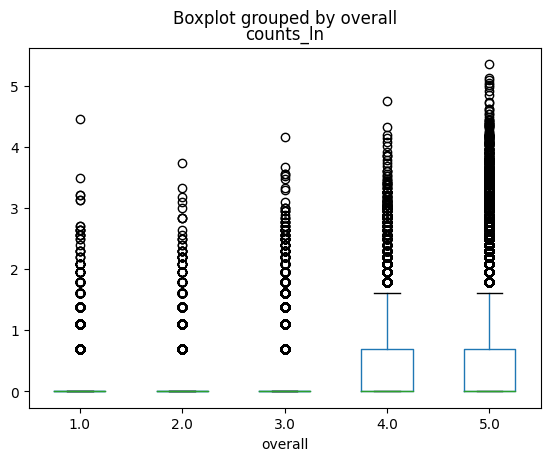

In [38]:
%matplotlib inline
df_observations['counts_ln'] = np.log(df_observations['counts'])
df_observations.boxplot(by="overall",column=['counts_ln'],grid=False)

#### En regardant le boxplot, on peut remarquer que les clients ont plus tendance a donner une note de 4 ou 5. On peux en deduire que Amazon propose beaucoup plus de bon livres que de mauvais.

## B- Annalyse PCA et Nuage de points

### 1) PCA

In [46]:
df_matrice = df_observations.pivot(index='overall', columns='asin')
df_matrice = df_matrice.fillna(0)
df_matrice = df_matrice.droplevel(0,axis=1)
df_matrice_pca_init = df_matrice.T.reset_index()
df_matrice_pca = df_matrice_pca_init.loc[:, df_matrice_pca_init.columns != 'asin']

In [90]:
rates = df_matrice_pca.columns.to_list()
x = df_matrice_pca.loc[:, rates].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=5)
pc = pca.fit_transform(x)
df_pc = pd.DataFrame(data = pc
             , columns = PCA_nbr)

In [91]:
print(f"On reconstruit les données à environ {round(pca.explained_variance_ratio_.cumsum()[-1]*100,1)} % avec {len(df_pc.columns)} composantes")
df_pc

On reconstruit les données à environ 100.0 % avec 5 composantes


,PC 1,PC 2,PC 3,PC 4,PC 5
0,2.010164,-2.170044,1.079283,-2.353388,3.450604
1,0.344416,-0.631400,0.088994,-0.269184,-1.518867
2,-0.405751,-0.052106,0.068411,-0.155037,0.275905
3,0.900143,-0.639775,0.109280,0.999543,1.180253
4,-0.405751,-0.052106,0.068411,-0.155037,0.275905
...,...,...,...,...,...
359843,-0.625379,0.140434,-0.023486,0.044813,-0.012704
359844,-0.625379,0.140434,-0.023486,0.044813,-0.012704
359845,-0.473145,0.006975,0.040212,-0.093713,0.187344
359846,-0.198002,-0.234231,0.155338,-0.344078,0.548903


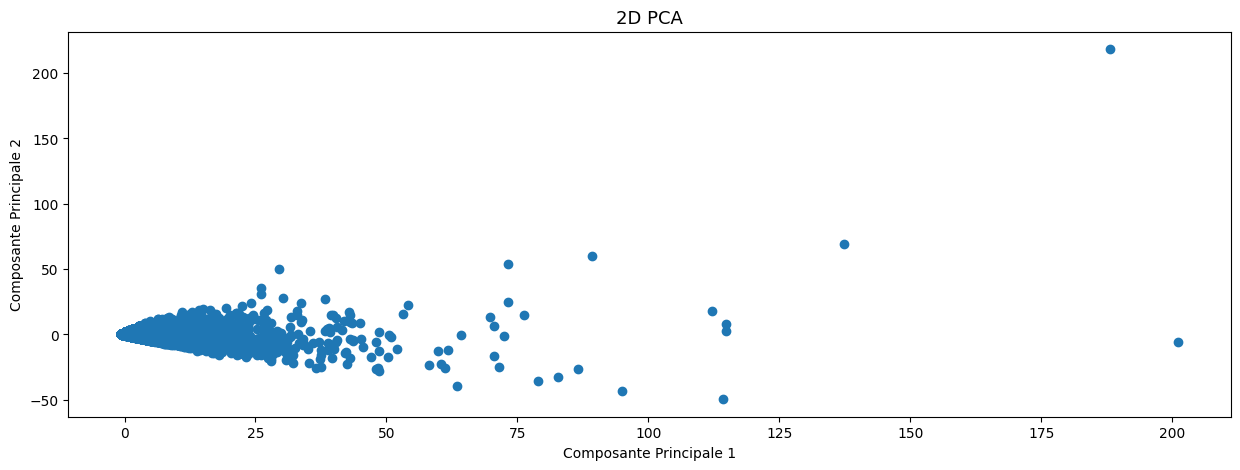

In [168]:
%matplotlib inline
pca_scatter2d(X=df_pc[PC_x],Y=df_pc[PC_y])

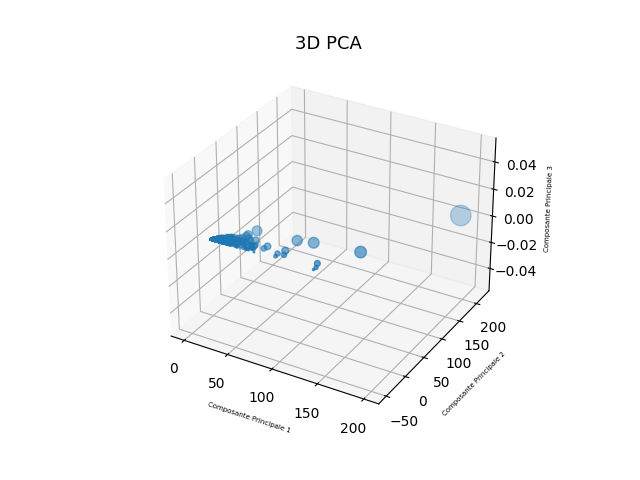

In [180]:
%matplotlib widget

pca_scatter3d(X=df_pc[PC_x],Y=df_pc[PC_y],Z=df_pc[PC_y])

### 2) En choisissant la moyenne ajuste on obtient

In [126]:
df_moyenne_pondere['moyenne_ajuste'].describe()

count    179924.000000
mean          6.474269
std           3.267388
min           1.000000
25%           4.232868
50%           5.000000
75%           8.465736
max          30.304031
Name: moyenne_ajuste, dtype: float64

In [128]:
df_matrice_colors = df_moyenne_pondere.copy()
color_conditions = [
    (df_matrice_colors['moyenne_ajuste'] <= categories_limites_ajuste[0]),
    (df_matrice_colors['moyenne_ajuste'] > categories_limites_ajuste[0]) & (df_matrice_colors['moyenne_ajuste'] < categories_limites_ajuste[1]),
    (df_matrice_colors['moyenne_ajuste'] >= categories_limites_ajuste[1])
    ]

df_matrice_colors['color'] = np.select(color_conditions, colors)


df_matrice_colors = df_matrice_colors.T
df_matrice_colors

asin,000100039X,0001055178,0001473905,000171287X,0001714538,0002006715,0002007770,0002008572,0002051850,0002113570,...,B00LY51TPA,B00LYGQXQY,B00LYH0JD6,B00LYM5AUI,B00LYPZJ4M,B00LZ4D0UC,B00LZ9OBWI,B00LZFHL7Y,B00LZKMXBI,B00M0RE7CS
moyenne_pondere,5.0,4.0,5.0,4.5,5.0,5.0,4.367742,5.0,4.7,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.875,5.0
note_median,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
moyenne_ajuste,17.424533,6.772589,5.0,10.738325,5.0,5.0,26.396121,8.465736,15.52215,5.0,...,8.465736,8.465736,8.465736,5.0,10.493061,5.0,5.0,8.465736,15.012278,8.465736
color,green,green,blue,green,blue,blue,green,green,green,blue,...,green,green,green,blue,green,blue,blue,green,green,green


In [129]:
df_tmp = df_matrice_colors.T.reset_index().iloc[0: , :].reset_index(drop=True)
df_tmp2 = pd.concat([df_pc, df_matrice_pca_init[['asin']]], axis = 1)
df_final = pd.merge(df_tmp, df_tmp2, on ='asin',how='inner')
df_final

,asin,moyenne_pondere,note_median,moyenne_ajuste,color,PC 1,PC 2,PC 3,PC 4,PC 5
0,000100039X,5.0,5.0,17.424533,green,2.010164,-2.170044,1.079283,-2.353388,3.450604
1,000100039X,5.0,5.0,17.424533,green,-0.079623,-0.338010,0.204870,-0.451796,0.704462
2,0001055178,4.0,4.0,6.772589,green,0.344416,-0.631400,0.088994,-0.269184,-1.518867
3,0001055178,4.0,4.0,6.772589,green,-0.289274,-0.127063,0.015496,-0.064010,-0.534701
4,0001473905,5.0,5.0,5.0,blue,-0.405751,-0.052106,0.068411,-0.155037,0.275905
...,...,...,...,...,...,...,...,...,...,...
359843,B00LZFHL7Y,5.0,5.0,8.465736,green,-0.473145,0.006975,0.040212,-0.093713,0.187344
359844,B00LZKMXBI,4.875,5.0,15.012278,green,1.396919,-1.593262,0.676036,-1.511136,1.254478
359845,B00LZKMXBI,4.875,5.0,15.012278,green,-0.198002,-0.234231,0.155338,-0.344078,0.548903
359846,B00M0RE7CS,5.0,5.0,8.465736,green,-0.186122,-0.244646,0.160309,-0.354888,0.564514


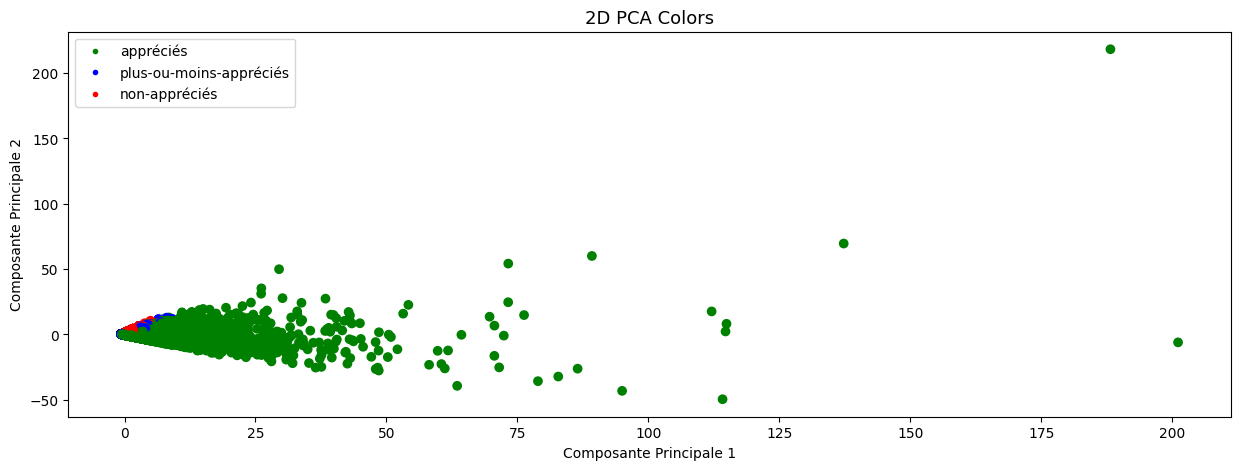

In [170]:
%matplotlib inline
colors_plt = df_final['color'].to_numpy()
pca_scatter2d(X=df_final[PC_x],Y=df_final[PC_y],c=colors_plt)

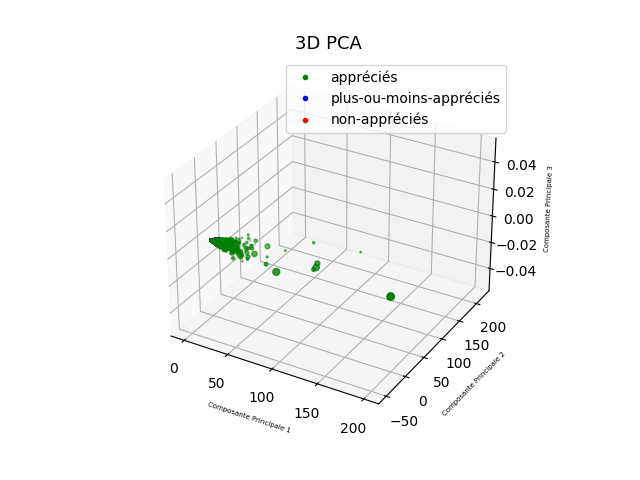

In [131]:
%matplotlib widget
pca_scatter3d(X=df_final[PC_x],Y=df_final[PC_y],Z=df_final[PC_z],c=colors_plt)

### 2) Histogramme des proportions de livres appréciés

<AxesSubplot: title={'center': 'Appreciation des livres'}, xlabel="Niveau d'appreciation">

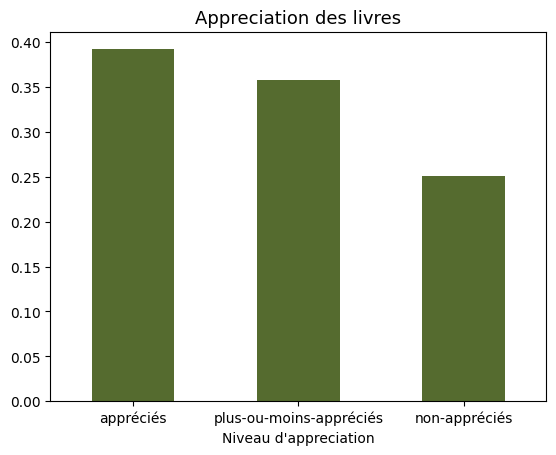

In [132]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel("Niveau d'appreciation", fontsize = 10)
ax.set_title('Appreciation des livres', fontsize = 13)

df_appreciation_hist = df_final["color"].value_counts(normalize=True)
index_df_appreciation_hist = df_appreciation_hist.index.map(lambda x: appreciation_color_map[x])
df_appreciation_hist.index = index_df_appreciation_hist
df_appreciation_hist.plot.bar(color='darkolivegreen',ax=ax,rot=0)

#### On peux donc observer sur l'histogramme qu'après avoir ajusté la moyenne, on obtient une repartition un peux plus balancée, avec un petit penchant pour les livres appréciés.

### 3) Triangle reliant les centres de groupe

In [133]:
df_centres = df_final.groupby(['color']).mean()[['PC 1','PC 2','PC 3']]
zip_centres = np.array(list(zip(df_centres["PC 1"].values, df_centres["PC 2"].values, df_centres["PC 3"].values)))
print(zip_centres)
zip_centres[:,:2]

[[-0.41617501  0.10930324 -0.01544252]
 [ 0.52529046 -0.24581139  0.0466472 ]
 [-0.22793536  0.22868829 -0.05096625]]


array([[-0.41617501,  0.10930324],
       [ 0.52529046, -0.24581139],
       [-0.22793536,  0.22868829]])

(-8.0, 8.0)

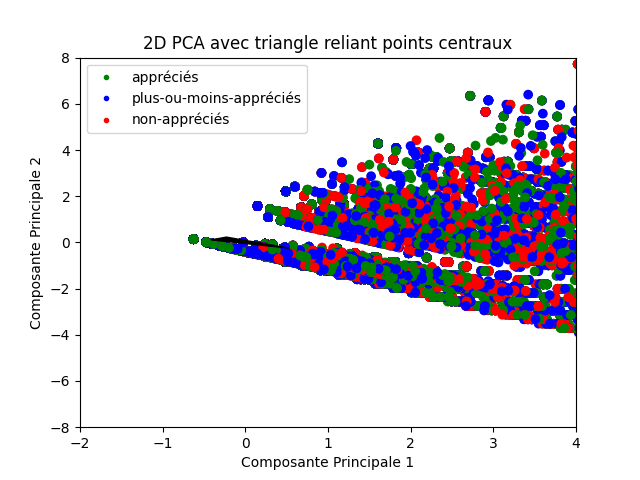

In [134]:
%matplotlib widget
colors_plt = df_final['color'].to_numpy()

pca_scatter2d(X=df_pc['PC 1'],Y=df_pc['PC 2'],c=colors_plt)
triangle_plot = plt.Polygon(zip_centres[:,:2],color='black')
plt.gca().add_patch(triangle_plot)
plt.title('2D PCA avec triangle reliant points centraux')
plt.xlim(-2,4)
plt.ylim(-8,8)

## C - Opinion en fonction du temps

### Utils

In [148]:
%matplotlib inline
df_mois = df_data.copy()
df_final_draw_pca = df_final.copy()

In [177]:
def description(df,df_pca,mois):
    
    print(100*'*')
    print(f"voici les informations pour le mois {mois}")
    df_mois = df.loc[df['reviewTime'].dt.month==mois]
    
    df_observations = df_data[['overall','asin']].value_counts().reset_index(name='counts')
    
    df_matrice_donnes = df_observations.pivot(index='overall', columns='asin')
    df_matrice_donnes = df_matrice_donnes.droplevel(0, axis=1)
    df_matrice_donnes = df_matrice_donnes.fillna(0)
    
    df_matrice_donnes.loc['total'] = df_matrice_donnes.sum()
    df_matrice_donnes.loc['total'] = df_matrice_donnes.sum()
    df_matrice_donnes_ = df_data[['asin','overall']].groupby('asin').agg(note_min=('overall', 'min'),
                                                                        note_max=('overall', 'max'),
                                                                        note_std=('overall', 'std'),
                                                                        note_median=('overall', 'median'),
                                                                        moyenne_pondere=('overall', 'mean')).fillna(0) 
    df_matrice_donnes_
    df_moyenne_pondere = df_matrice_donnes_[['moyenne_pondere','note_median']]


    df_matrice_donnes_description = pd.concat([df_matrice_donnes,df_matrice_donnes_.T])
    
    
    df_tmp1 = df_data['asin'].value_counts().rename_axis('asin').to_frame('counts')
    df_tmp2 = df_moyenne_pondere[["moyenne_pondere"]]
    df_tmp3 = df_tmp2.merge(df_tmp1,on='asin')

    df_moyenne_pondere["moyenne_ajuste"] = df_tmp3.apply(lambda x: pond_moyenne(x["moyenne_pondere"],x["counts"]),axis=1)
    df_matrice_finale = pd.concat([df_matrice_donnes,df_moyenne_pondere.T])

    
    print(f"La matrice pour le mois {mois}:")
    print(df_matrice_finale.iloc[: , :2])
    print(50*'-')

    top_livres_m = df_moyenne_pondere.loc[df_moyenne_pondere['moyenne_ajuste'] > categories_limites_ajuste[0]]
    top_livres_m = top_livres_m.sort_values(by=['moyenne_ajuste'], ascending=False)
    print('Le top des livres les plus appréciés basé sur la moyenne ajuste sont:')
    print(top_livres_m.head(1))
    print(50*'-')

    bottom_livres_m = df_moyenne_pondere.loc[df_moyenne_pondere['moyenne_ajuste'] <= categories_limites_ajuste[1]]
    bottom_livres_m = bottom_livres_m.sort_values(by=['moyenne_ajuste'], ascending=True)
    print('Les les moins appréciés basé sur la moyenne ajuste sont:')
    print(bottom_livres_m.head(1))
    print(50*'-')

    quartile = top_livres_m.quantile(0.25)
    print("Le premier quart des livres les plus appéciés est: ",quartile.values[0])
    print(50*'-')

    df_final = df_pca.merge(df_mois, how='inner', on='asin')[['asin','color','PC 1','PC 2','PC 3','PC 4','PC 5']]
    

    df_appreciation_hist = df_final["color"].value_counts(normalize=False)
    index_df_appreciation_hist = df_appreciation_hist.index.map(lambda x: appreciation_color_map[x])
    df_appreciation_hist.index = index_df_appreciation_hist

    colors_plt = df_final['color'].to_numpy()
    title = f'2D PCA Mois {mois}'
    pca_scatter2d(X=df_final[PC_x],Y=df_final[PC_y],c=colors_plt,bar=True,df_bar=df_appreciation_hist,title =title)
    return df_matrice_finale

### Etudes mensuel sur 12 Mois

****************************************************************************************************
voici les informations pour le mois 1
La matrice pour le mois 1:
asin             000100039X  0001055178
1.0                0.000000    0.000000
2.0                0.000000    0.000000
3.0                0.000000    0.000000
4.0                0.000000    2.000000
5.0               12.000000    0.000000
total             24.000000    4.000000
moyenne_pondere    5.000000    4.000000
note_median        5.000000    4.000000
moyenne_ajuste    17.424533    6.772589
--------------------------------------------------
Le top des livres les plus appréciés basé sur la moyenne ajuste sont:
            moyenne_pondere  note_median  moyenne_ajuste
asin                                                    
0439023483         4.492013          5.0       30.304031
--------------------------------------------------
Les les moins appréciés basé sur la moyenne ajuste sont:
            moyenne_pondere  note_

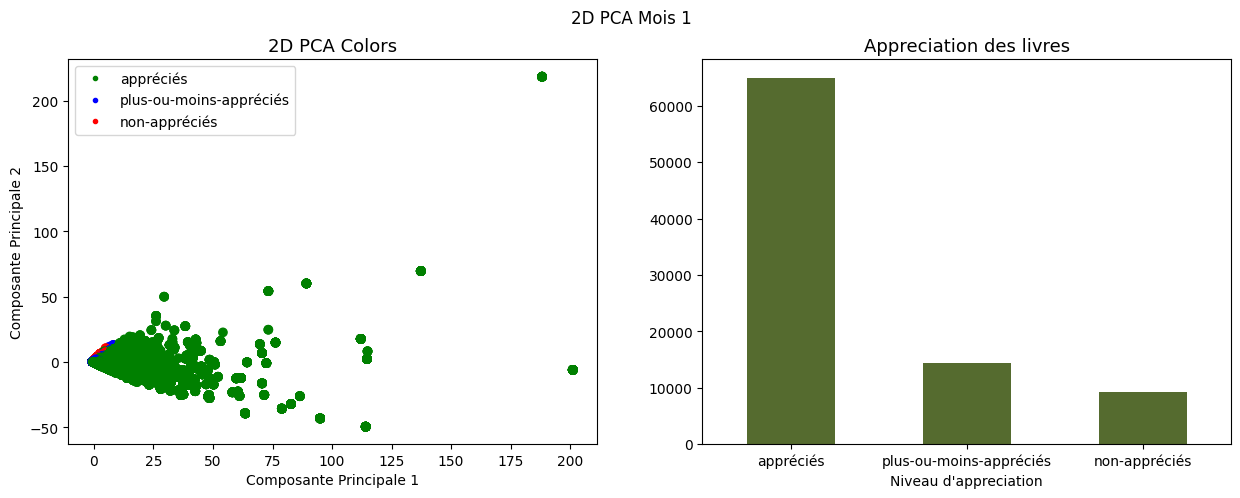

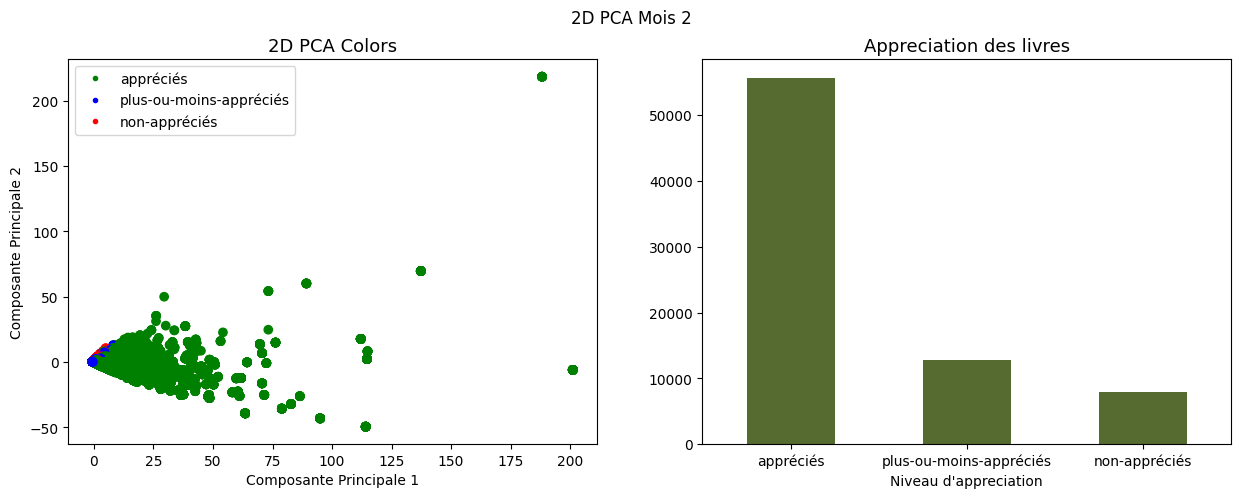

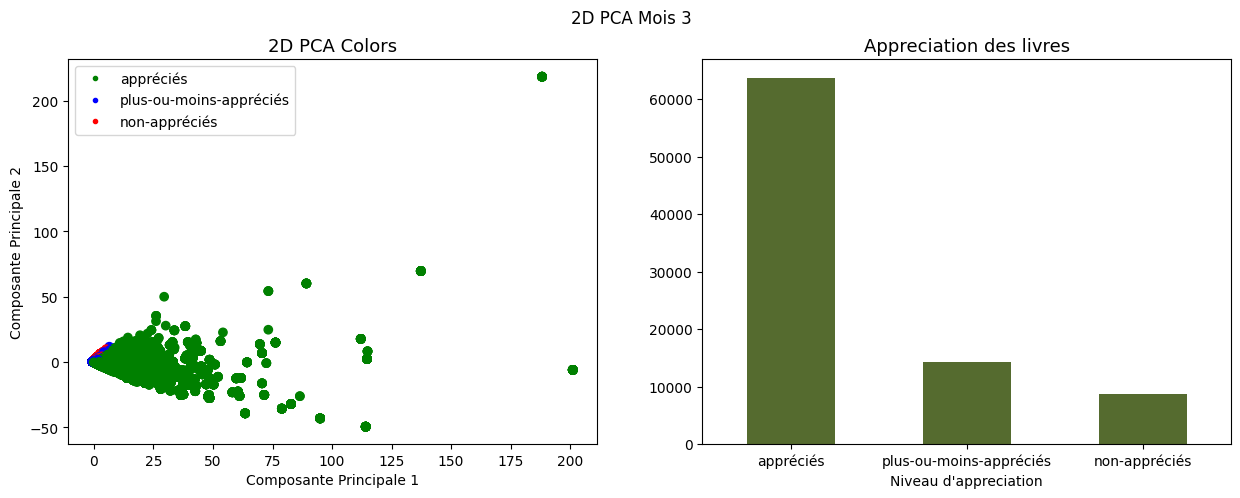

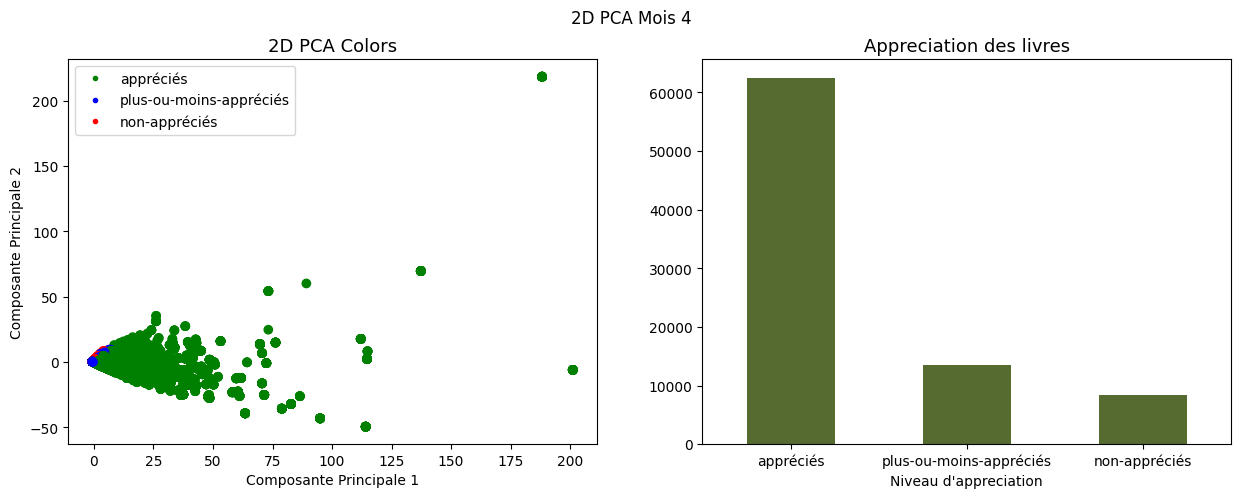

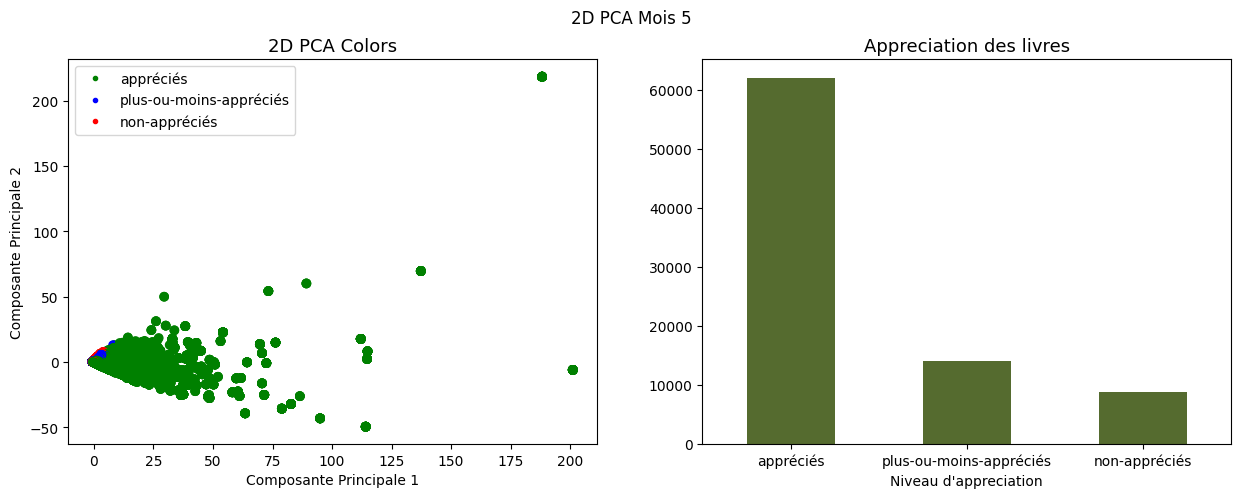

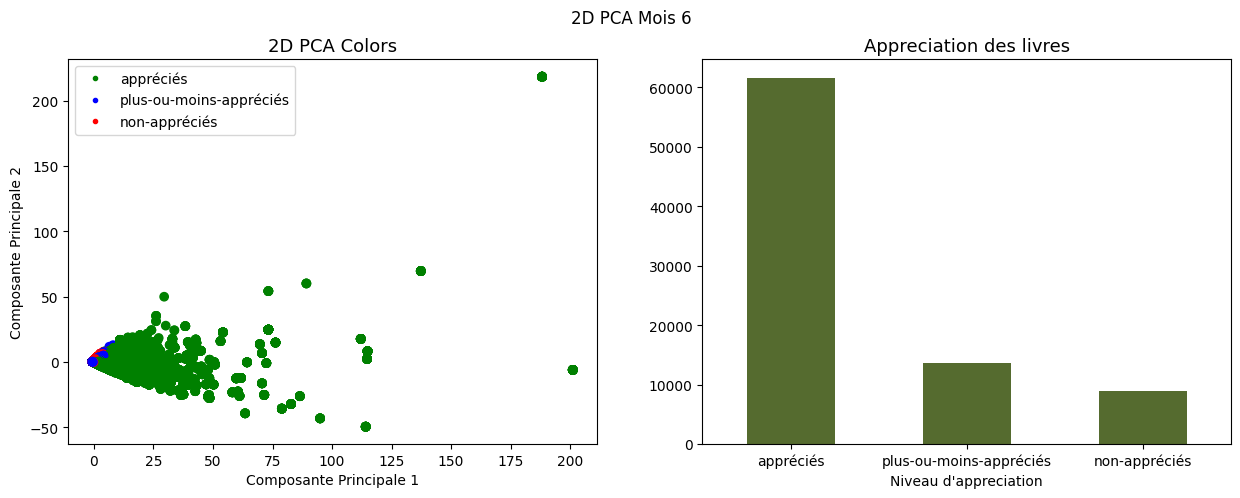

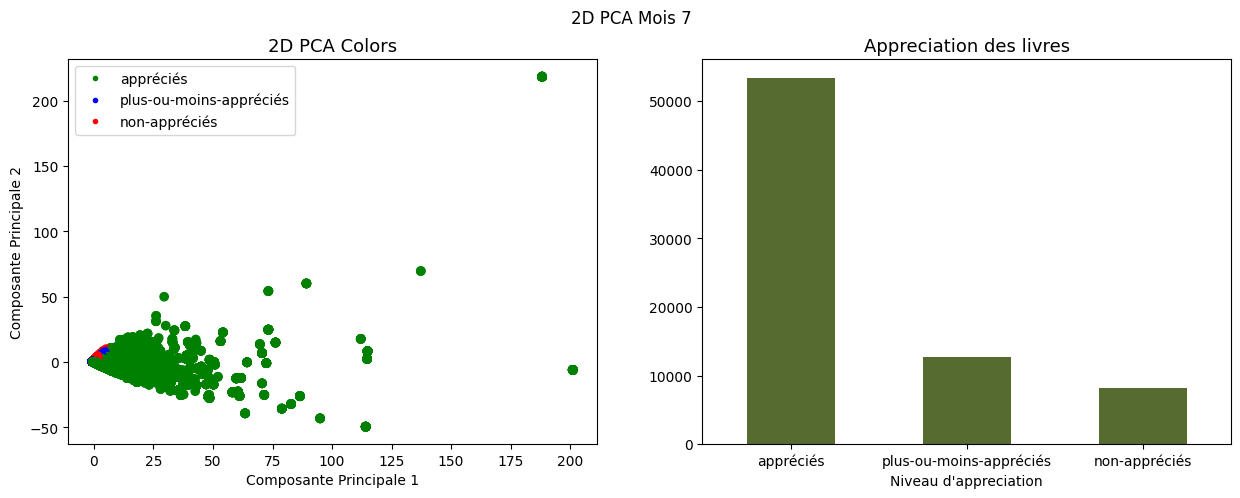

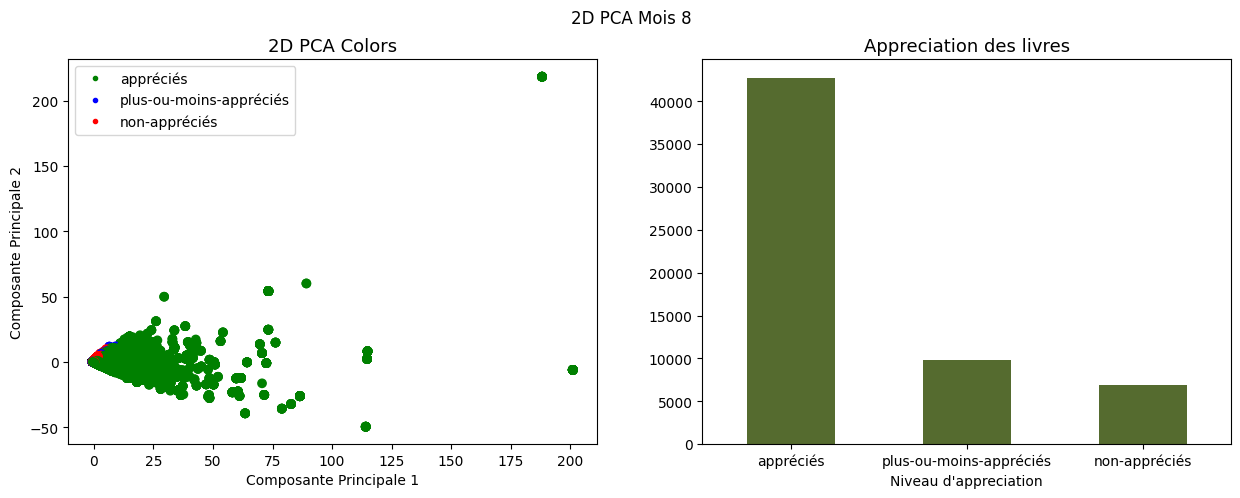

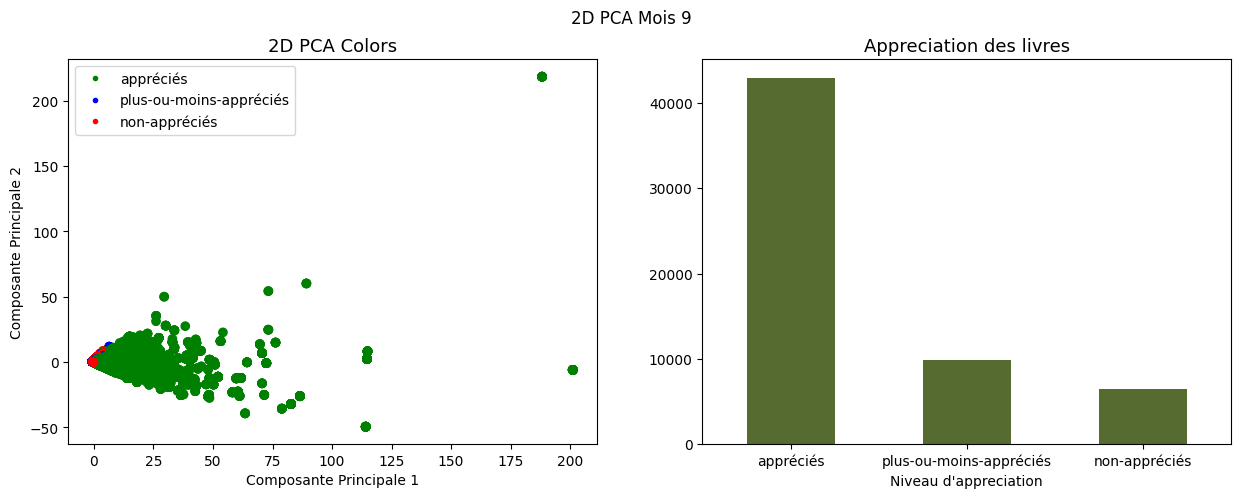

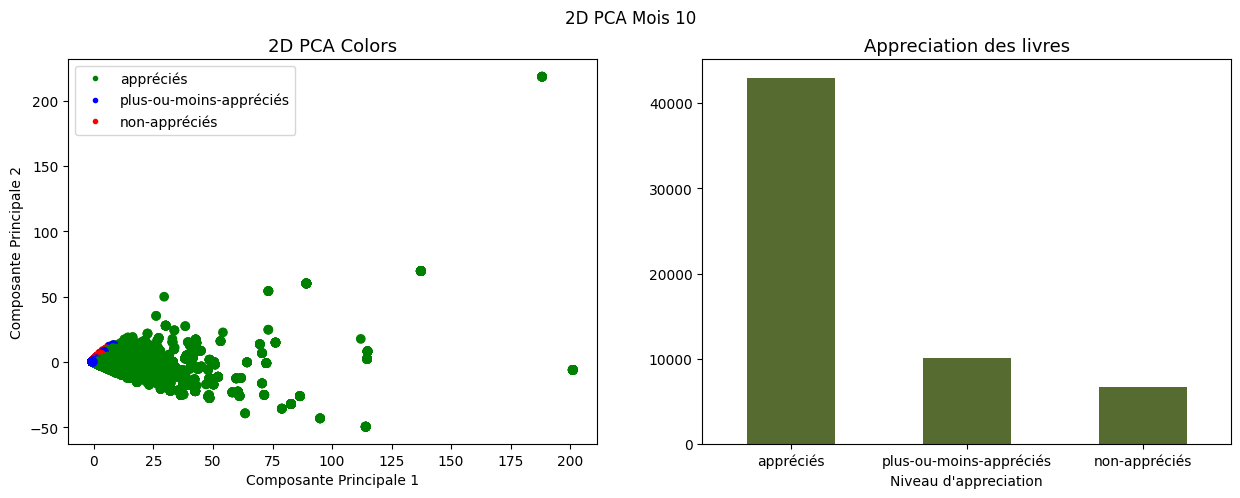

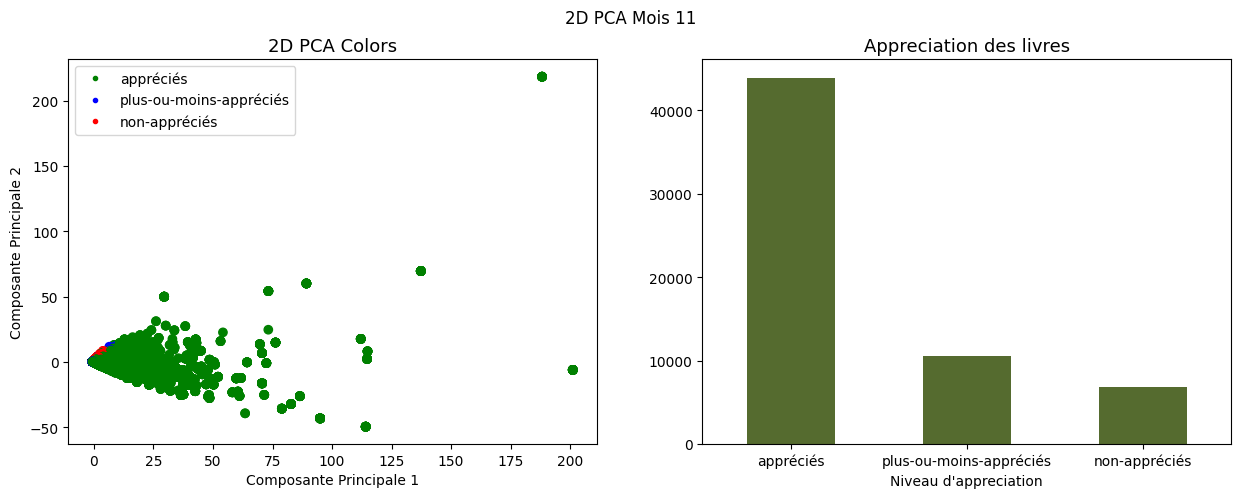

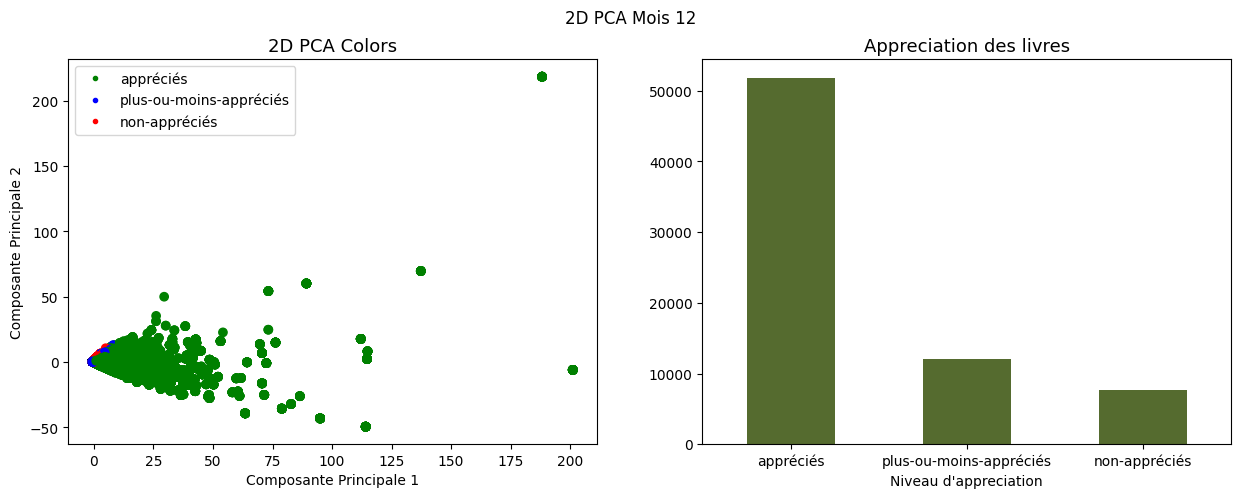

In [179]:
matrices_par_mois = []
for i in range(1,13):
    df_description = description(df_mois,df_final_draw_pca,i)
    matrices_par_mois.append(df_description)
    plt.savefig(f'./images/{i}.png')

### En regardant les 12 mois on peux remarquer que la proportion de livres apprécié est toujours similaire, meme si on enregistre plus de notes dans certains mois que d'autres, la proportion reste quand équivalente. On peux donc en déduire que la compagnie propose de bons livres peux importe la période de l'année. 